In [1]:
import math
import sys
sys.path.insert(0,'..')
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from src.utilities import DataHandler

# KPIs
---

In [2]:
evaluation_data = DataHandler.get_concat_data('reward_tuning', 'evaluation')
evaluation_data['lower_exponent'] = evaluation_data['reward_function_kwargs'].map(lambda x: x['lower_exponent'] if x is not None else None)
evaluation_data['higher_exponent'] = evaluation_data['reward_function_kwargs'].map(lambda x: x['higher_exponent'] if x is not None else None)
evaluation_data.loc[(~evaluation_data['id'].str.contains('building_all')), 'central_agent'] = 'Decentralized'
evaluation_data = evaluation_data[(evaluation_data['higher_exponent'] <= evaluation_data['lower_exponent'] + 1.0)].copy()
evaluation_data.head()

environment  annual_normalized_unserved_energy_total  annual_peak_average  \
0       20199                                      0.0                  NaN   
1    District                                      0.0             0.874399   
2      481052                                      0.0                  NaN   
3    District                                      0.0             0.910879   
4       75252                                      0.0                  NaN   

  carbon_emissions_total cost_total  daily_one_minus_load_factor_average  \
0                   None       None                                  NaN   
1                   None       None                             1.154437   
2                   None       None                                  NaN   
3                   None       None                             1.072045   
4                   None       None                                  NaN   

   daily_peak_average  discomfort_delta_average  discomfort_delta_maximum  \
0                 NaN                 -1.078030                 26.674440   
1            0.865559                 -1.078030                 26.674440   
2                 NaN                 -1.420586                  0.754425   
3            0.929385                 -1.420586                  0.754425   
4                 NaN                 -3.487964                  7.234644   

   discomfort_delta_minimum  ...  zero_net_energy  \
0                 -4.434683  ...         0.814529   
1                 -4.434683  ...         0.814529   
2                 -7.747612  ...         0.893328   
3                 -7.747612  ...         0.893328   
4                -11.060980  ...         0.876596   

                                                  id            library  \
0  lod_2-stable_baselines3-sac-norbc-centralized-...  stable-baselines3   
1  lod_2-stable_baselines3-sac-norbc-centralized-...  stable-baselines3   
2  lod_2-stable_baselines3-sac-norbc-centralized-...  stable-baselines3   
3  lod_2-stable_baselines3-sac-norbc-centralized-...  stable-baselines3   
4  lod_2-stable_baselines3-sac-norbc-centralized-...  stable-baselines3   

   agent  rbc_name  central_agent  reward_function_name  \
0    SAC     NoRBC  Decentralized         ComfortReward   
1    SAC     NoRBC  Decentralized         ComfortReward   
2    SAC     NoRBC  Decentralized         ComfortReward   
3    SAC     NoRBC  Decentralized         ComfortReward   
4    SAC     NoRBC  Decentralized         ComfortReward   

                            reward_function_kwargs  lower_exponent  \
0  {'lower_exponent': 1.2, 'higher_exponent': 1.6}             1.2   
1  {'lower_exponent': 1.2, 'higher_exponent': 1.6}             1.2   
2  {'lower_exponent': 1.4, 'higher_exponent': 2.4}             1.4   
3  {'lower_exponent': 1.4, 'higher_exponent': 2.4}             1.4   
4  {'lower_exponent': 1.8, 'higher_exponent': 2.4}             1.8   

  higher_exponent  
0             1.6  
1             1.6  
2             2.4  
3             2.4  
4             2.4  

[5 rows x 28 columns]

## Comparison between centralized and decentralized agents building-level discomfort hours

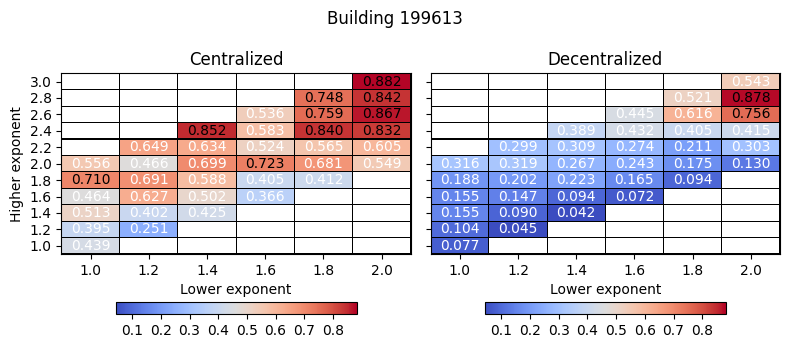

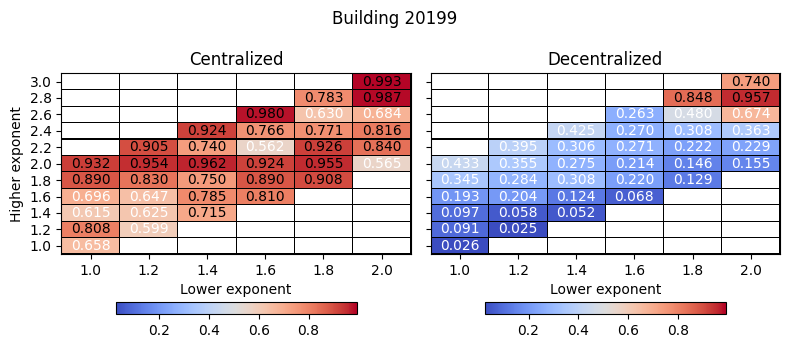

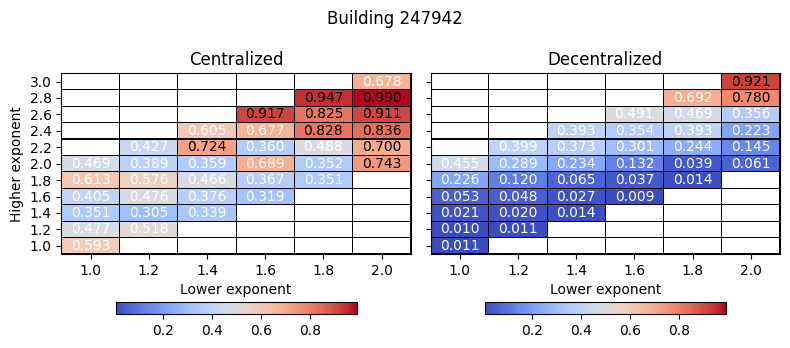

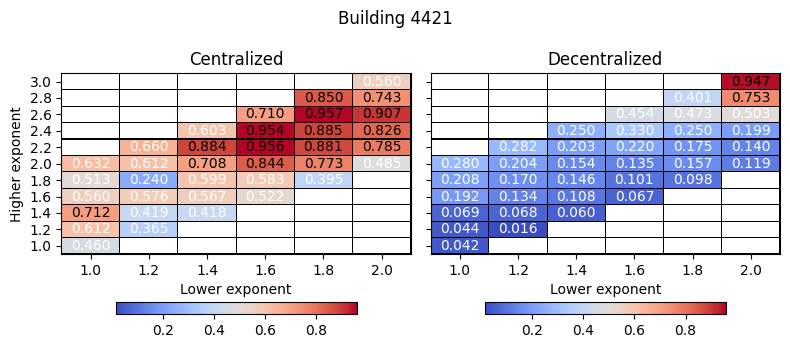

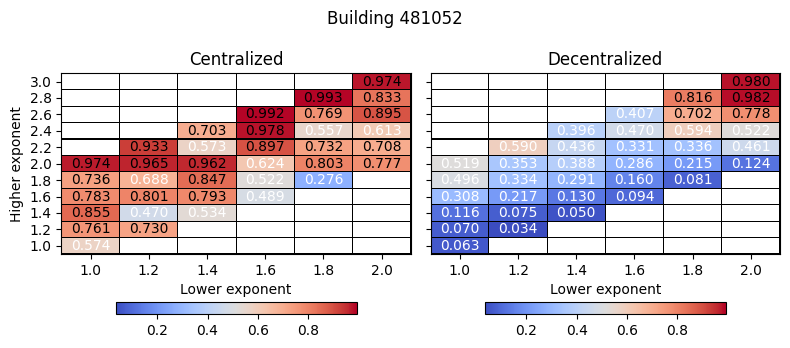

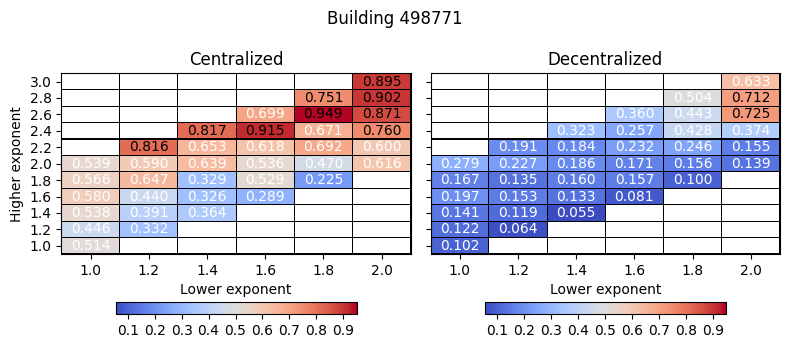

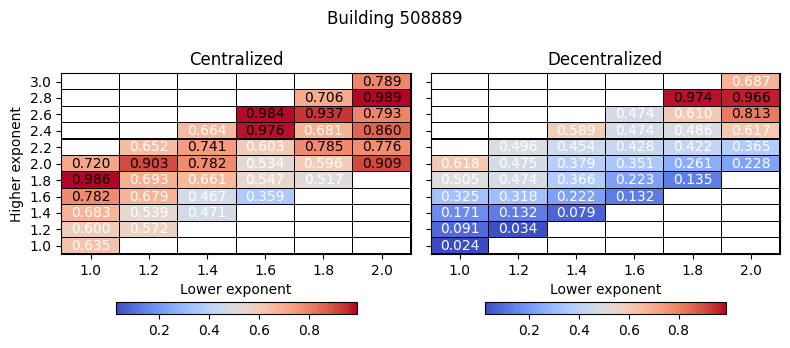

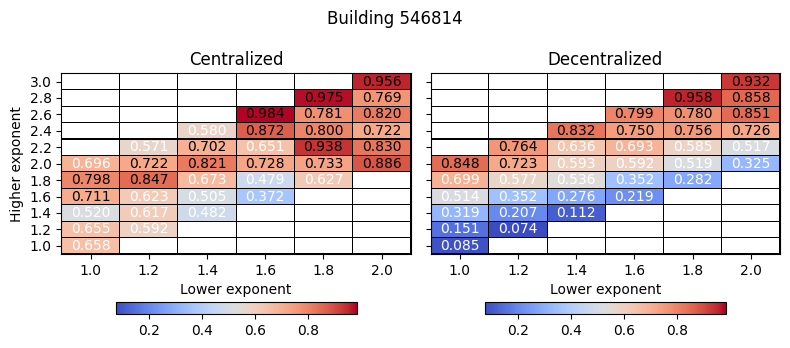

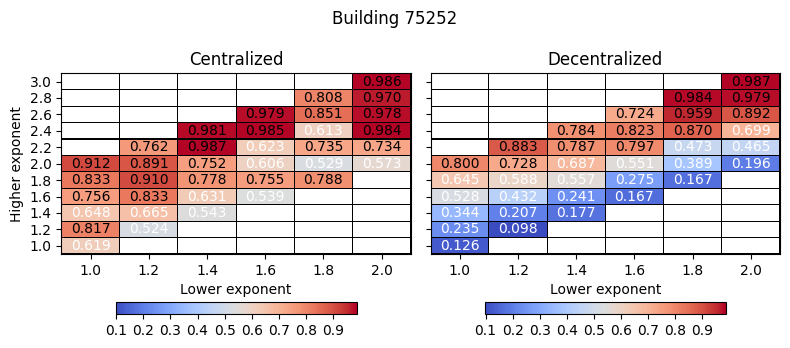

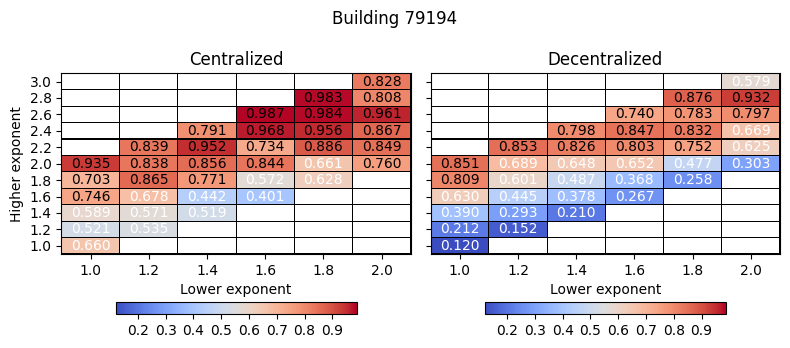

In [3]:
cmap = 'coolwarm'
column = 'discomfort_proportion'
plot_data = evaluation_data[(evaluation_data['environment']!='District')].copy()
column_count = 2
row_count = 1

for b, bdata in plot_data.groupby('environment'):
    fig, axs = plt.subplots(row_count, column_count, figsize=(4*column_count, 3.5), sharey=True)
    vmin = bdata[column].min()
    vmax = bdata[column].max()
    vcenter = vmin + (vmax - vmin)/2.0
    divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

    for i, (ax, (central_agent, cdata)) in enumerate(zip(fig.axes, bdata.groupby('central_agent'))):
        plot_data = cdata.pivot(index='higher_exponent', columns='lower_exponent', values=column)
        x, y, z = plot_data.columns, plot_data.index, plot_data.values
        pcm = ax.pcolormesh(x, y, z, shading='nearest', cmap=cmap, norm=divnorm, edgecolors='black', linewidth=0.1)
        ax.set_xlabel('Lower exponent')

        if i == 0:
            ax.set_ylabel('Higher exponent')
        else:
            pass

        ax.set_xticks(x)
        ax.set_yticks(y)
        ax.set_title(central_agent)

        for (j, k), z in np.ndenumerate(plot_data):
            color = 'black' if 0.7 <= z <= 1.4 else 'white'
            ax.text(x[k], y[j], f'{z:0.3f}', ha='center', va='center', color=color)

        cb = fig.colorbar(pcm, ax=ax, orientation='horizontal', label=None, fraction=0.05, pad=0.2)

    fig.suptitle(f'Building {b}')
    plt.tight_layout()
    plt.show()

- Decentralized control provides better building-level comfort.
- Increasing delta between lower and higher exponents worsens comfort.
- Each building should have a decentralized controller with unique exponents to maximize comfort performance.

## Comparison of discomfort, electricity consumption and peak when reward exponents are varied for decentralized control

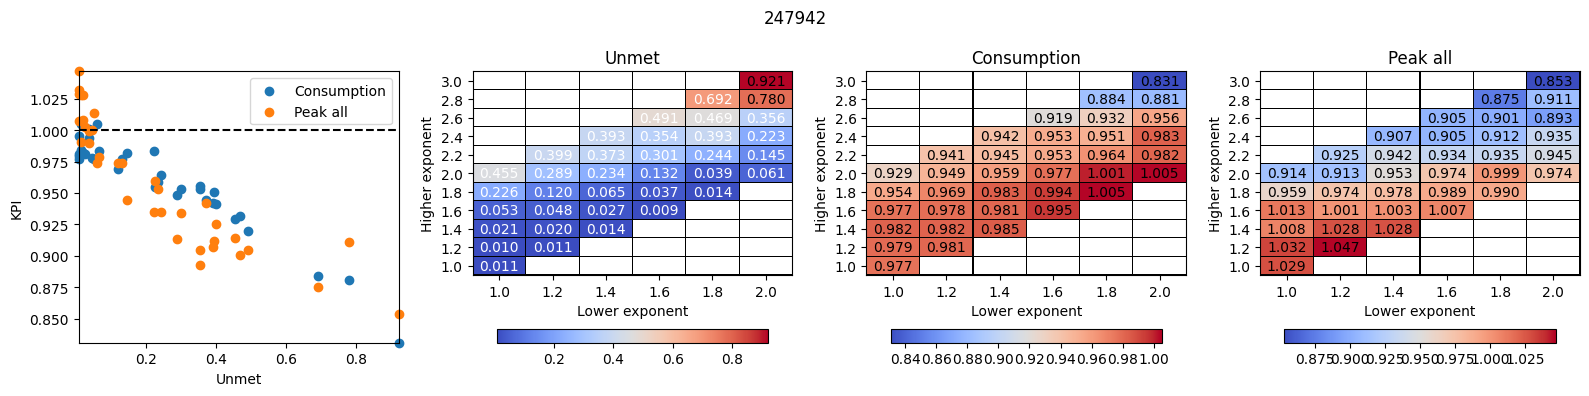

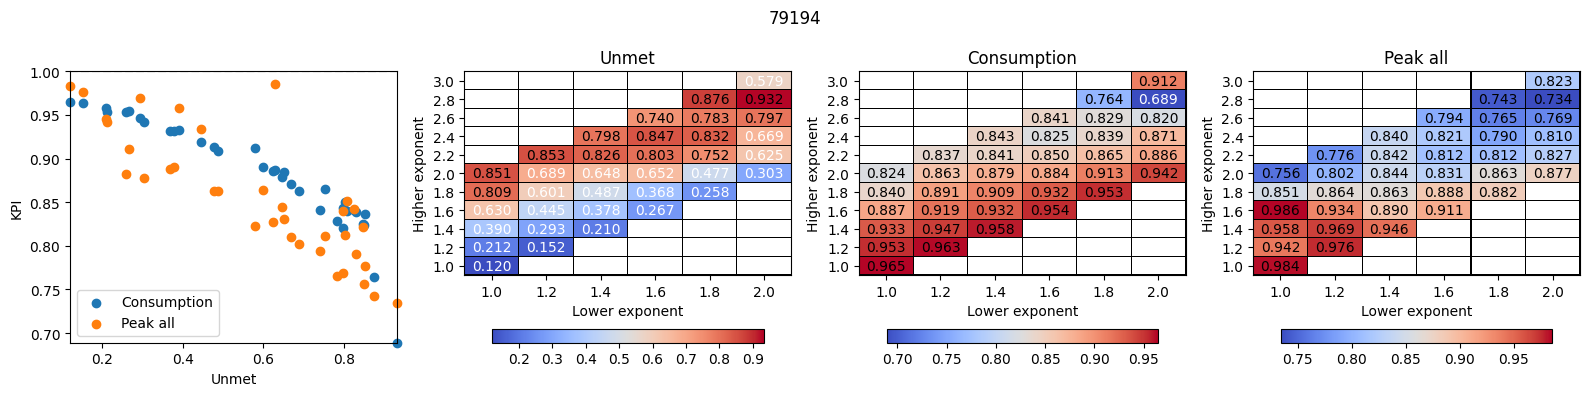

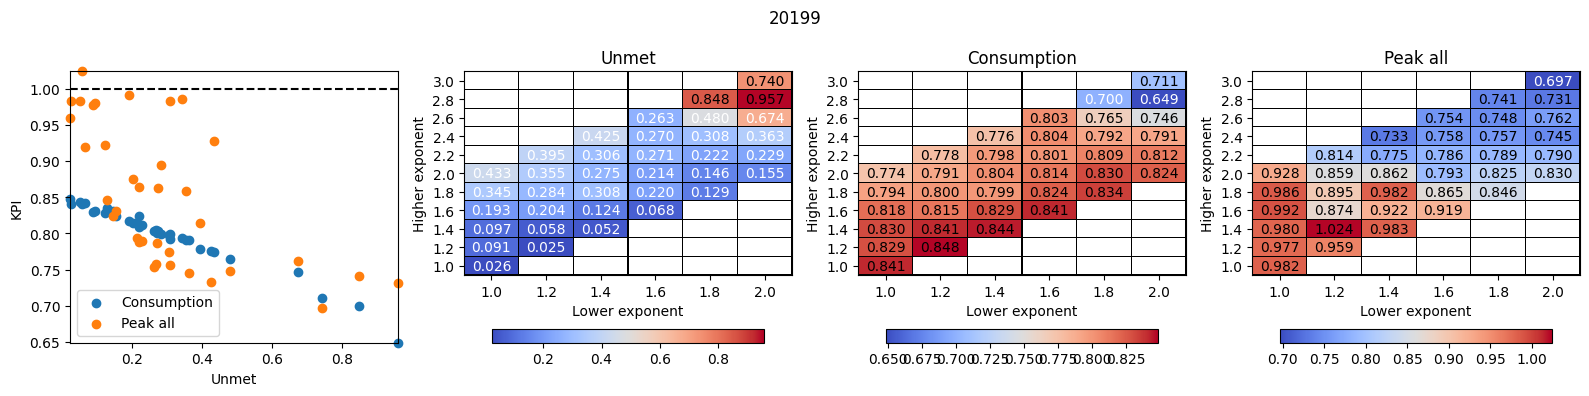

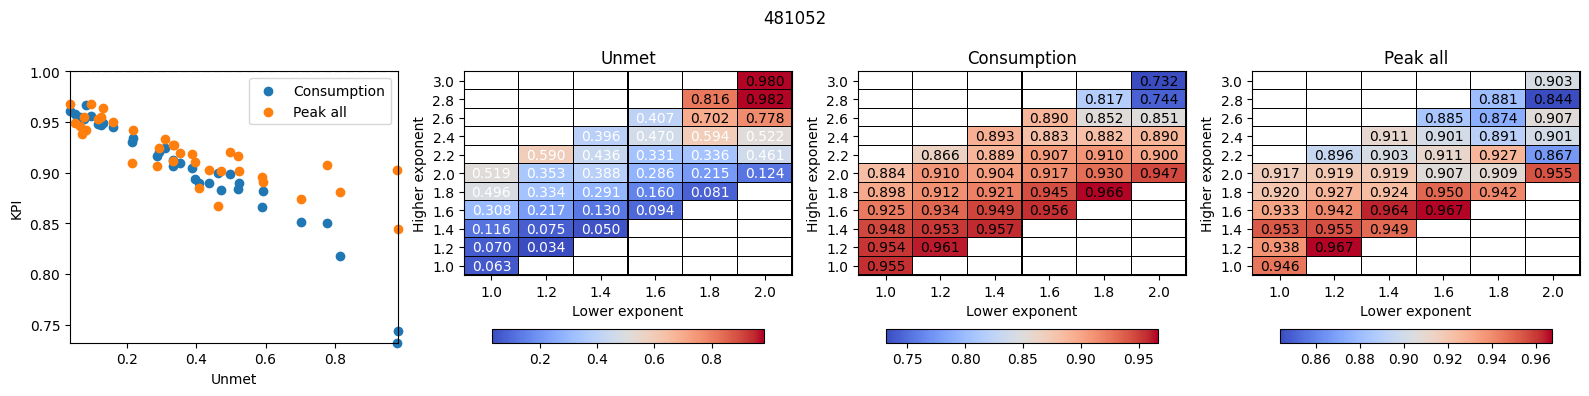

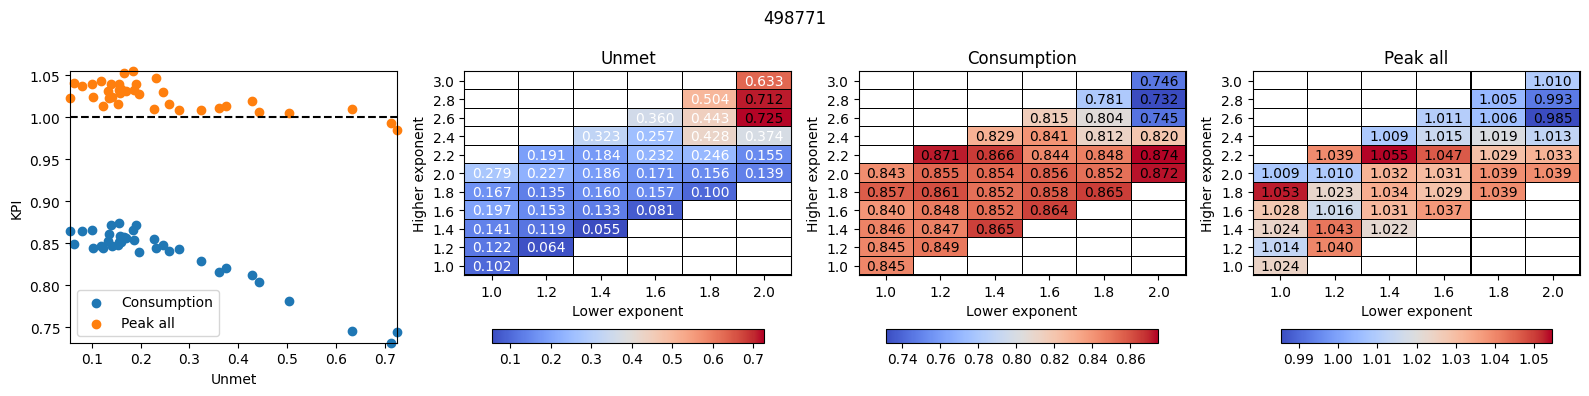

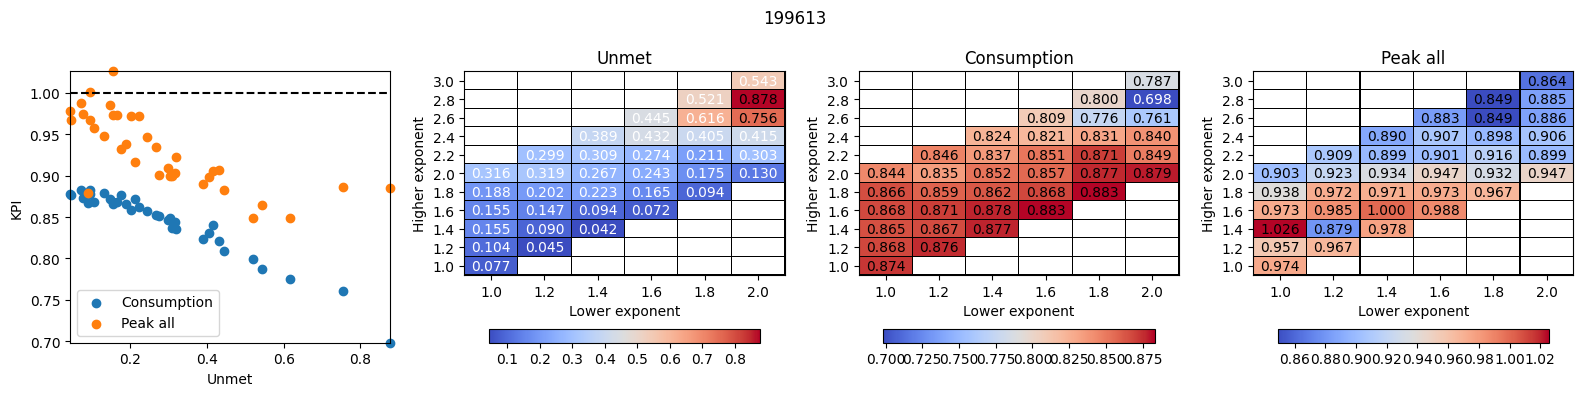

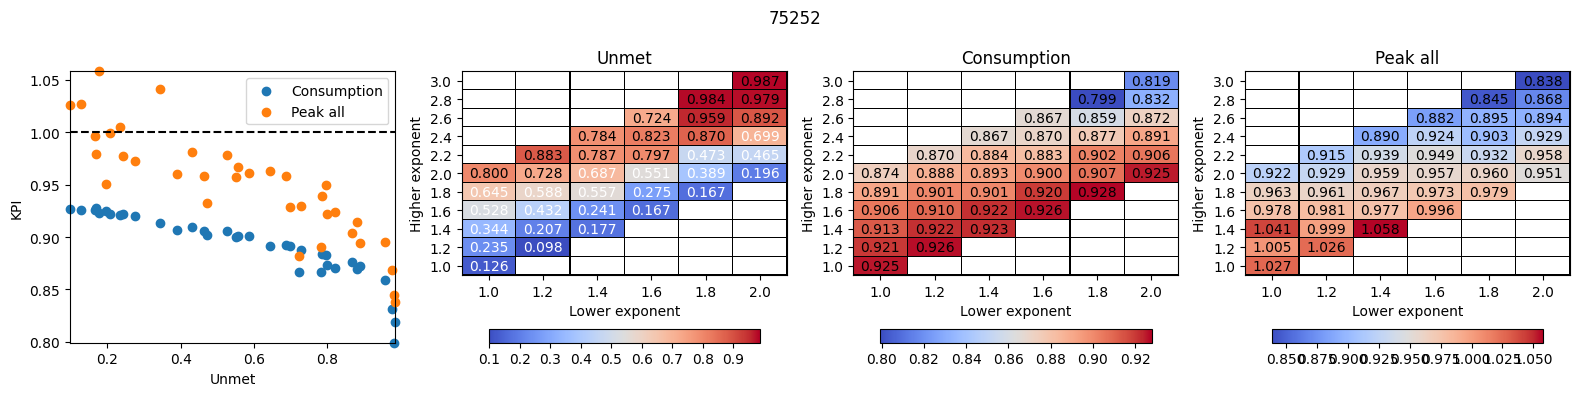

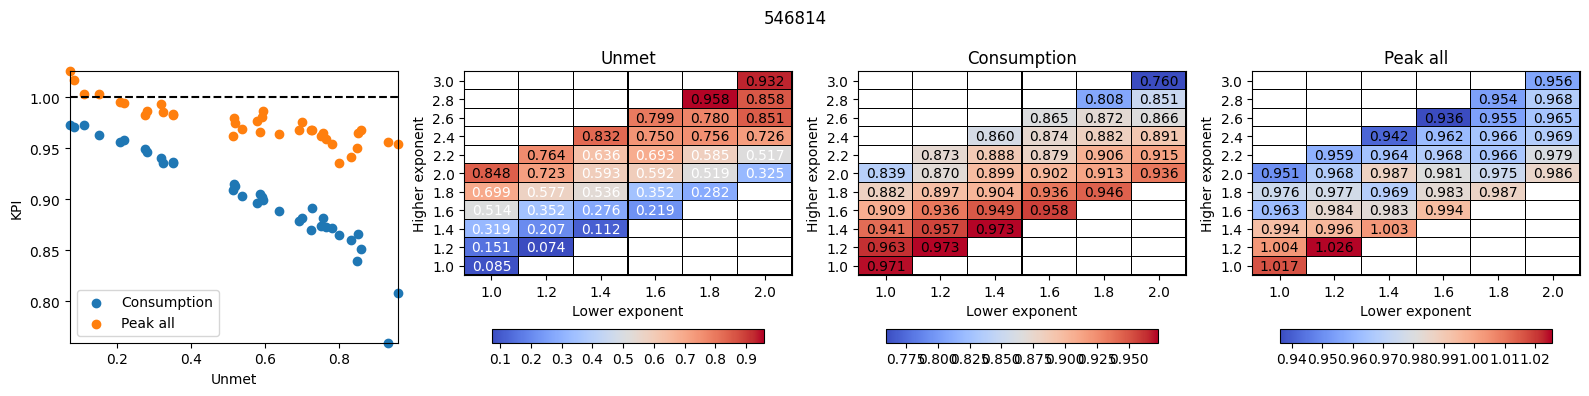

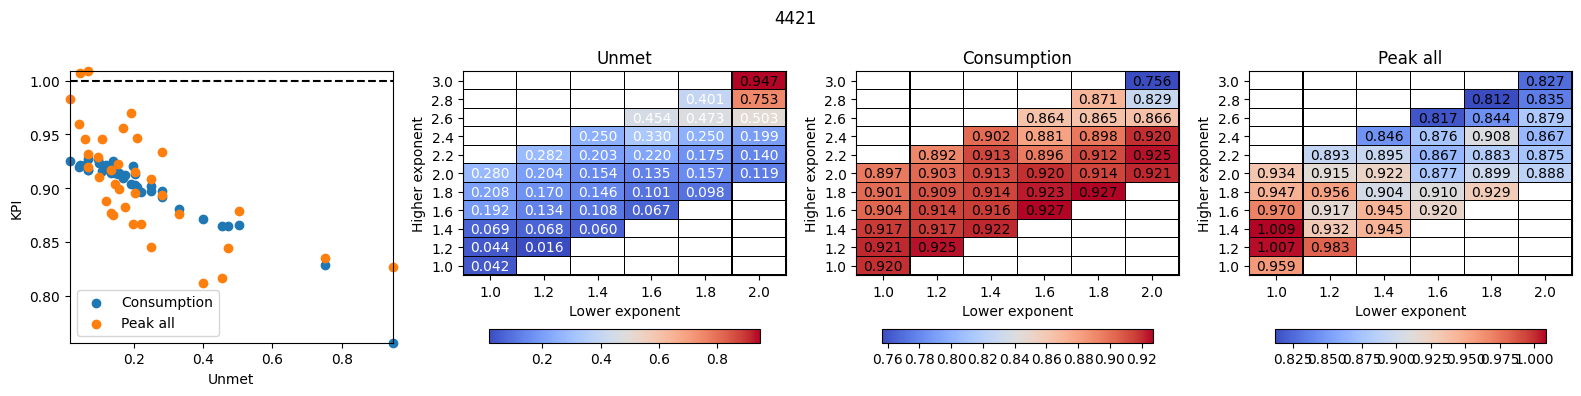

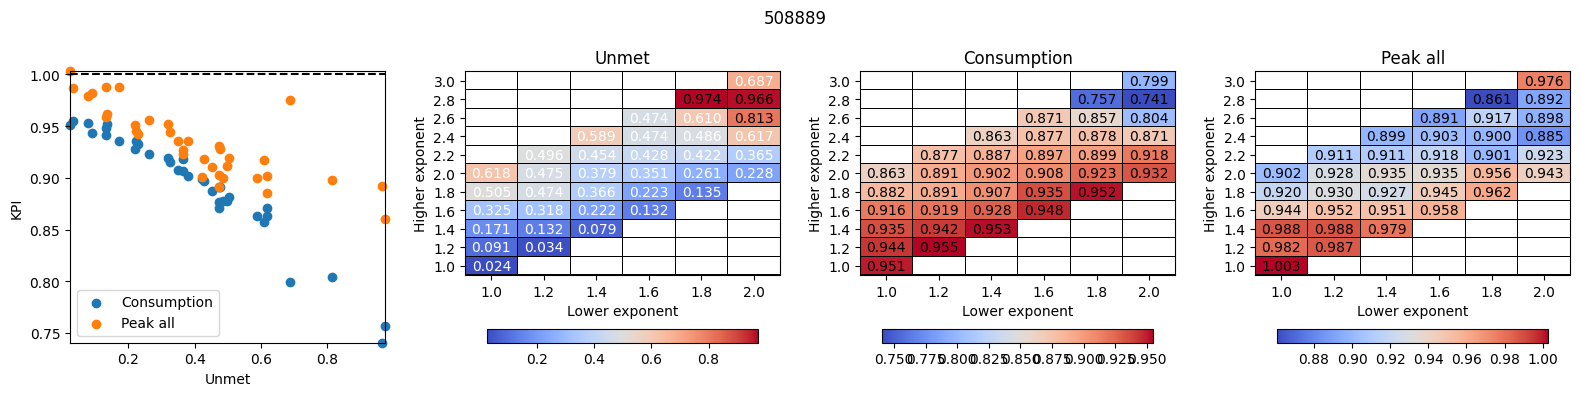

In [4]:
cmap = 'coolwarm'
columns = [
    'discomfort_proportion',
    'electricity_consumption_total',
    'annual_peak_average',
    # 'daily_one_minus_load_factor_average',
    # 'daily_peak_average',
    # 'ramping_average',
]
column_count_limit = 5
row_count = math.ceil((len(columns) + 1)/column_count_limit)
column_count = min(len(columns) + 1, column_count_limit)
plot_data = evaluation_data[(evaluation_data['central_agent']=='Decentralized')].copy()
plot_data['building_name'] = plot_data['id'].str.split('-', expand=True)[6]

for _, bdata in plot_data.groupby('building_name'):
    b = bdata[(bdata['environment']!='District')]['environment'].iloc[0]
    bdata = bdata[(bdata['environment']=='District')].copy()
    fig, axs = plt.subplots(row_count, column_count, figsize=(4*column_count, 4*row_count),)

    # scatter plot
    x = bdata[columns[0]].tolist()

    for c in columns[1:]:
        y = bdata[c].tolist()
        fig.axes[0].scatter(x, y, clip_on=False, label=DataHandler.KPI_LABELS[c])

    fig.axes[0].axhline(1.0, color='black', linestyle='--')
    fig.axes[0].set_xlabel(DataHandler.KPI_LABELS[columns[0]])
    fig.axes[0].set_ylabel('KPI')
    fig.axes[0].margins(0)
    fig.axes[0].legend()

    for ax in fig.axes[len(columns) + 1:]:
        fig.delaxes(ax)

    for i, (ax, c) in enumerate(zip(fig.axes[1:], columns)):
        vmin = bdata[c].min()
        vmax = bdata[c].max()
        vcenter = vmin + (vmax - vmin)/2.0
        divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
        plot_data = bdata.pivot(index='higher_exponent', columns='lower_exponent', values=c)
        x, y, z = plot_data.columns, plot_data.index, plot_data.values
        pcm = ax.pcolormesh(x, y, z, shading='nearest', cmap=cmap, norm=divnorm, edgecolors='black', linewidth=0.1)
        ax.set_xlabel('Lower exponent')
        ax.set_ylabel('Higher exponent')
        ax.set_xticks(x)
        ax.set_yticks(y)
        ax.set_title(DataHandler.KPI_LABELS[c])

        for (j, k), z in np.ndenumerate(plot_data):
            color = 'black' if 0.7 <= z <= 1.4 else 'white'
            ax.text(x[k], y[j], f'{z:0.3f}', ha='center', va='center', color=color)

        cb = fig.colorbar(pcm, ax=ax, orientation='horizontal', label=None, fraction=0.05, pad=0.2)

    fig.suptitle(f'{b}')
    plt.tight_layout()
    plt.show()

- Discomfort is inversely related to electricity consumption and peak.
- All exponent combinations is all buildings but 247942 result in reduced electricity consumption compared to the baseline.
- For the majority, peak is reduced.
- Will pick combination that minimizes discomfort in each building

In [5]:
plot_data = evaluation_data[
    (evaluation_data['central_agent']=='Decentralized')
    & (evaluation_data['environment']!='District')
].copy()
plot_data['building_name'] = plot_data['id'].str.split('-', expand=True)[6]
plot_data['building_index'] = plot_data['building_name'].str.split('_', expand=True)[1].astype(int) - 1
plot_data['minimum_discomfort_proportion'] = plot_data.groupby(['environment', 'building_index', 'building_name'])[['discomfort_proportion']].transform(min)
plot_data = plot_data[plot_data['minimum_discomfort_proportion']==plot_data['discomfort_proportion']].copy()
plot_data = plot_data[['building_index', 'building_name', 'environment', 'lower_exponent', 'higher_exponent', 'discomfort_proportion']].sort_values('building_index')
display(plot_data)

building_index building_name environment  lower_exponent  \
251                0    building_1      247942             1.6   
736                1    building_2       20199             1.2   
433                2    building_3      481052             1.2   
193                3    building_4      498771             1.4   
983                4    building_5      199613             1.4   
151                5    building_6       75252             1.2   
961                6    building_7      546814             1.2   
1047               7    building_8        4421             1.2   
971                8    building_9      508889             1.0   
168                9   building_10       79194             1.0   

      higher_exponent  discomfort_proportion  
251               1.6               0.008637  
736               1.2               0.024617  
433               1.2               0.034346  
193               1.4               0.055439  
983               1.4               0.042492  
151               1.2               0.097504  
961               1.2               0.073593  
1047              1.2               0.016106  
971               1.0               0.024433  
168               1.0               0.120020

# Other Sanity Checks using Building 3 (481052)

## Temperature Profiles

In [6]:
time_series_data = DataHandler.get_concat_data('building_3-reward_tuning', 'time_series')
time_series_data = time_series_data.merge(evaluation_data[['id', 'lower_exponent', 'higher_exponent']], on=['id'], how='inner')
time_series_data.head()

bldg_name  net_electricity_consumption  \
0    481052                     3.549666   
1    481052                     3.549666   
2    481052                     3.314902   
3    481052                     3.314902   
4    481052                     3.327730   

   net_electricity_consumption_without_storage  \
0                                     3.549666   
1                                     3.549666   
2                                     3.314902   
3                                     3.314902   
4                                     3.327730   

   net_electricity_consumption_without_storage_and_partial_load  \
0                                           3.549666              
1                                           3.549666              
2                                           3.314902              
3                                           3.314902              
4                                           3.327730              

   net_electricity_consumption_without_storage_and_partial_load_and_pv  \
0                                           3.549666                     
1                                           3.549666                     
2                                           3.314902                     
3                                           3.314902                     
4                                           3.327730                     

   indoor_dry_bulb_temperature  \
0                    19.544359   
1                    19.544359   
2                    19.481224   
3                    19.481224   
4                    19.438789   

   indoor_dry_bulb_temperature_without_partial_load  \
0                                         19.544359   
1                                         19.544359   
2                                         19.481224   
3                                         19.481224   
4                                         19.438789   

   indoor_dry_bulb_temperature_set_point  \
0                              18.944445   
1                              18.944445   
2                              18.944445   
3                              18.944445   
4                              18.944445   

   indoor_dry_bulb_temperature_set_point_without_control  occupant_count  ...  \
0                                          18.944445                 1.0  ...   
1                                          18.944445                 1.0  ...   
2                                          18.944445                 1.0  ...   
3                                          18.944445                 1.0  ...   
4                                          18.944445                 1.0  ...   

   environment                                                 id  \
0       481052  lod_2-stable_baselines3-sac-norbc-centralized-...   
1       481052  lod_2-stable_baselines3-sac-norbc-centralized-...   
2       481052  lod_2-stable_baselines3-sac-norbc-centralized-...   
3       481052  lod_2-stable_baselines3-sac-norbc-centralized-...   
4       481052  lod_2-stable_baselines3-sac-norbc-centralized-...   

             library  agent  rbc_name  central_agent  reward_function_name  \
0  stable-baselines3    SAC     NoRBC    Centralized         ComfortReward   
1  stable-baselines3    SAC     NoRBC    Centralized         ComfortReward   
2  stable-baselines3    SAC     NoRBC    Centralized         ComfortReward   
3  stable-baselines3    SAC     NoRBC    Centralized         ComfortReward   
4  stable-baselines3    SAC     NoRBC    Centralized         ComfortReward   

                            reward_function_kwargs  lower_exponent  \
0  {'lower_exponent': 1.4, 'higher_exponent': 2.4}             1.4   
1  {'lower_exponent': 1.4, 'higher_exponent': 2.4}             1.4   
2  {'lower_exponent': 1.4, 'higher_exponent': 2.4}             1.4   
3  {'lower_exponent': 1.4, 'higher_exponent': 2.4}             1.4   
4  {'lower_exponent': 1.4, 'higher_exponent': 2.4}             1.4

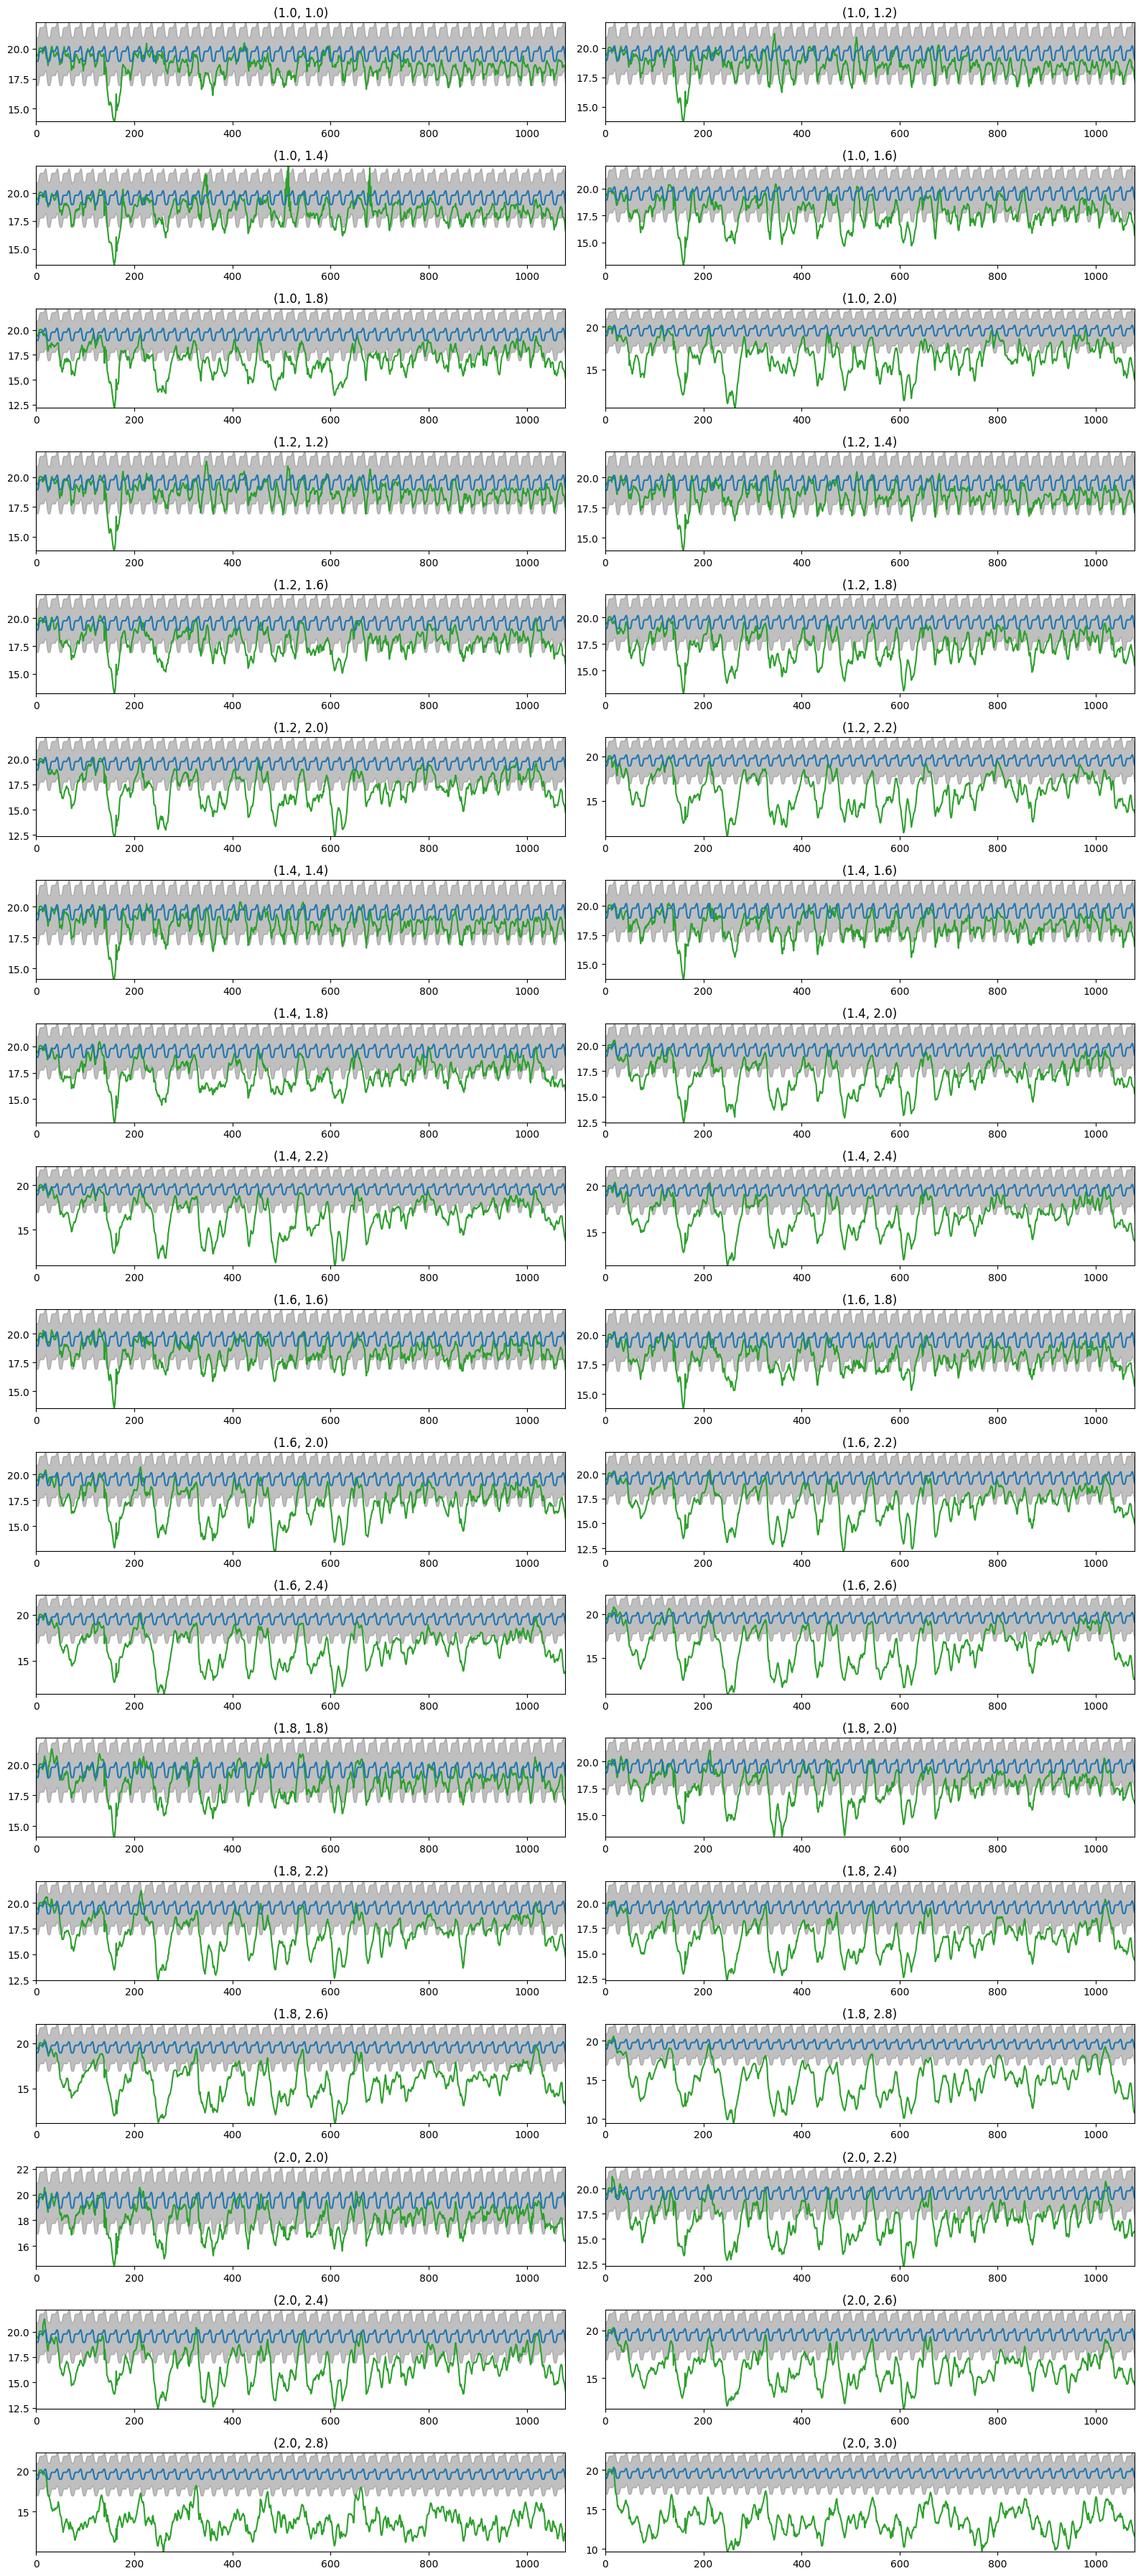

In [7]:
column_count_limit = 2
simulation_ids = time_series_data['id'].unique()
row_count = math.ceil(len(simulation_ids)/column_count_limit)
column_count = min(column_count_limit, len(simulation_ids))
fig, axs = plt.subplots(row_count, column_count, figsize=(8*column_count, 2.0*row_count))
start_ix, end_ix = 0, 2159

for ax in fig.axes[len(simulation_ids):]:
    fig.delaxes(ax)

for i, (ax, ((l, h), pdata)) in enumerate(zip(fig.axes, time_series_data.groupby(['lower_exponent', 'higher_exponent']))):
    pdata = pdata.iloc[start_ix:end_ix]
    x = pdata['time_step'].tolist()
    y = pdata['indoor_dry_bulb_temperature'].tolist()
    ax.plot(x, y, color='tab:green')
    y = pdata['indoor_dry_bulb_temperature_set_point'].tolist()
    ax.plot(x, y, color='tab:blue')
    y1 = pdata['indoor_dry_bulb_temperature_set_point'] - 2.0
    y2 = pdata['indoor_dry_bulb_temperature_set_point'] + 2.0
    ax.fill_between(x, y1.tolist(), y2.tolist(), color='grey', alpha=0.5)
    ax.set_title(f'({l}, {h})')
    ax.margins(0)

plt.tight_layout()
plt.show()

## Reward Convergence

In [8]:
reward_data = DataHandler.get_concat_data('building_3-reward_tuning', 'rewards')
reward_data = reward_data.merge(evaluation_data[['id', 'lower_exponent', 'higher_exponent']], on=['id'], how='inner')
reward_data.head()

min       max            sum        mean  episode environment  \
0 -2098.616699  0.000000 -222665.343750 -103.133553        0    District   
1 -2098.616699  0.000000 -222665.343750 -103.133553        0    District   
2  -122.310677  0.000000 -134432.796875  -62.266232        1    District   
3  -122.310677  0.000000 -134432.796875  -62.266232        1    District   
4  -120.172920 -0.046974 -122500.828125  -56.739616        2    District   

                                                  id            library agent  \
0  lod_2-stable_baselines3-sac-norbc-centralized-...  stable-baselines3   SAC   
1  lod_2-stable_baselines3-sac-norbc-centralized-...  stable-baselines3   SAC   
2  lod_2-stable_baselines3-sac-norbc-centralized-...  stable-baselines3   SAC   
3  lod_2-stable_baselines3-sac-norbc-centralized-...  stable-baselines3   SAC   
4  lod_2-stable_baselines3-sac-norbc-centralized-...  stable-baselines3   SAC   

  rbc_name central_agent reward_function_name  \
0    NoRBC   Centralized        ComfortReward   
1    NoRBC   Centralized        ComfortReward   
2    NoRBC   Centralized        ComfortReward   
3    NoRBC   Centralized        ComfortReward   
4    NoRBC   Centralized        ComfortReward   

                            reward_function_kwargs  lower_exponent  \
0  {'lower_exponent': 1.4, 'higher_exponent': 2.4}             1.4   
1  {'lower_exponent': 1.4, 'higher_exponent': 2.4}             1.4   
2  {'lower_exponent': 1.4, 'higher_exponent': 2.4}             1.4   
3  {'lower_exponent': 1.4, 'higher_exponent': 2.4}             1.4   
4  {'lower_exponent': 1.4, 'higher_exponent': 2.4}             1.4   

   higher_exponent  
0              2.4  
1              2.4  
2              2.4  
3              2.4  
4              2.4

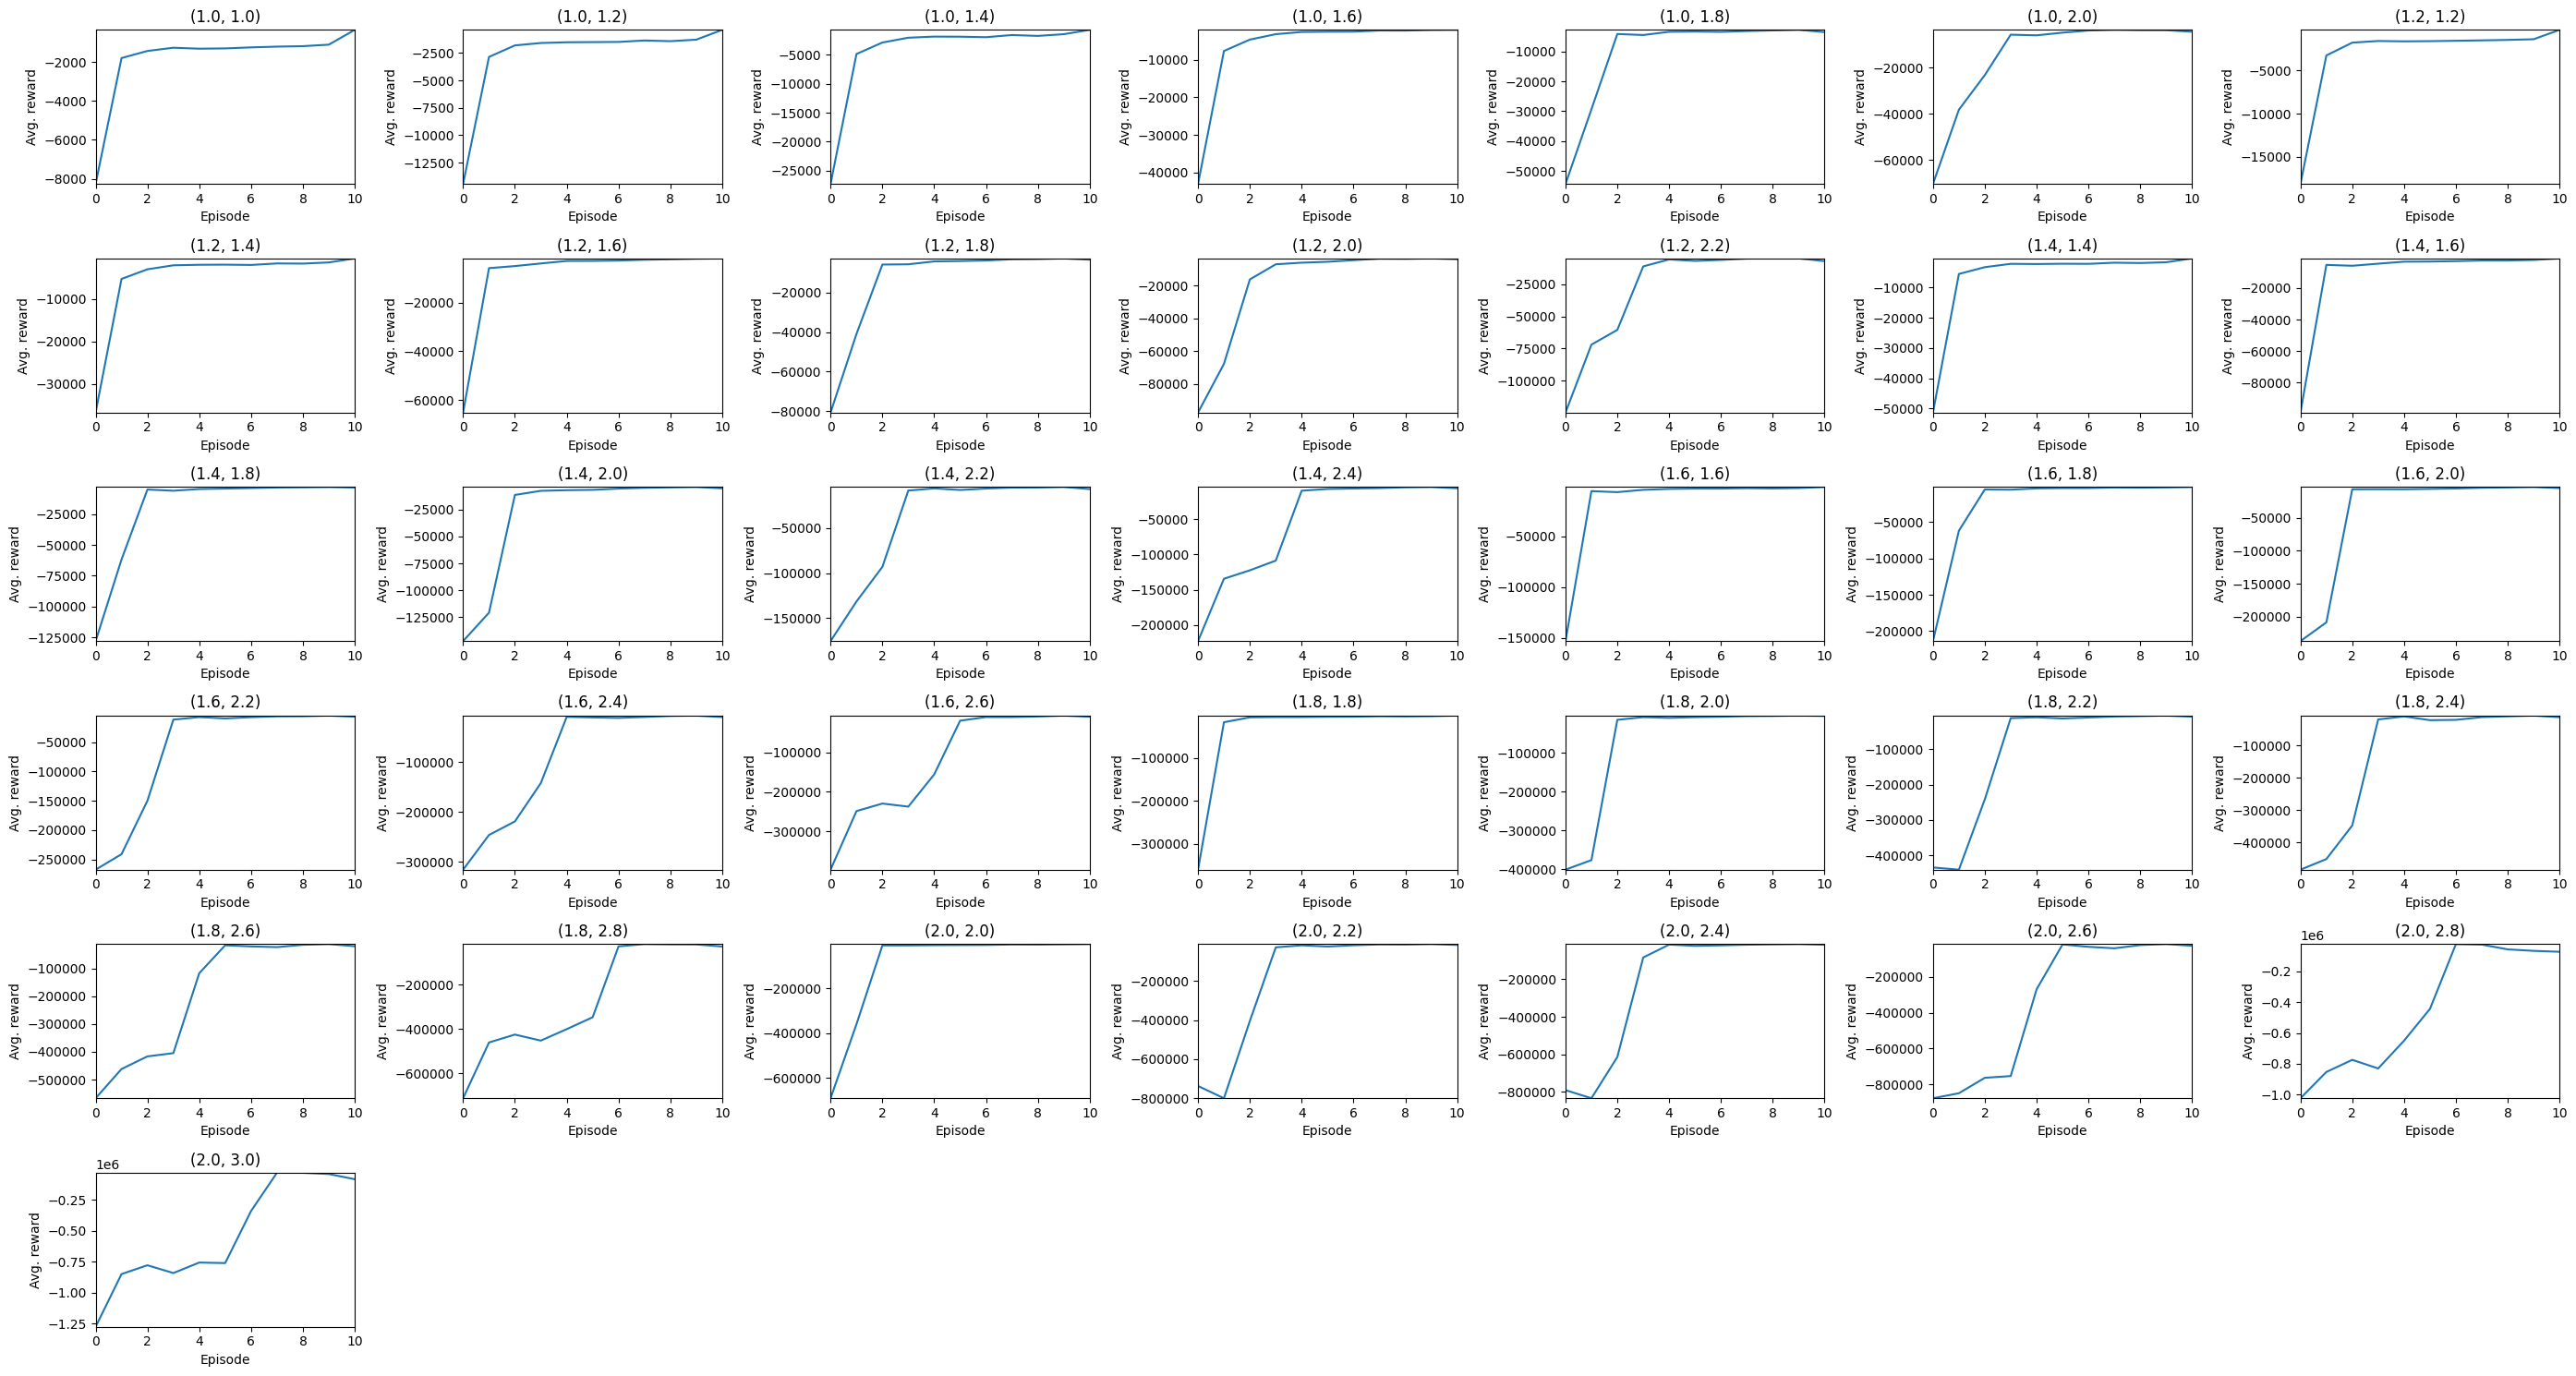

In [9]:
column_count_limit = 7
simulation_ids = reward_data['id'].unique()
row_count = math.ceil(len(simulation_ids)/column_count_limit)
column_count = min(len(simulation_ids), column_count_limit)
fig, axs = plt.subplots(row_count, column_count, figsize=(4*column_count, 2.5*row_count))

for ax in fig.axes[len(simulation_ids):]:
    fig.delaxes(ax)

for i, (ax, ((l, h), rdata)) in enumerate(zip(fig.axes, reward_data.groupby(['lower_exponent', 'higher_exponent']))):
    x = rdata['episode'].tolist()
    y = rdata['sum'].tolist()
    ax.plot(x, y)
    ax.set_title(f'({l}, {h})')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Avg. reward')
    ax.set_xticks(range(0, max(x) + 2, 2))
    ax.margins(0)
    
plt.tight_layout()
plt.show()